In [1]:
# EDA and data handling
import numpy as np 
import pandas as pd 
import pickle

import os
import matplotlib.pyplot as plt

# Modeling
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics

In [2]:
sklearn.__version__

'0.21.2'

In [3]:
movies = pd.read_csv('../data/tmdb_movie_plots.csv')
movies.shape

(3410, 22)

In [4]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,top_genre,year
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Action,2009
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Adventure,2007


In [5]:
movies = movies[['title', 'overview', 'year', 'popularity', 'top_genre']].copy()

In [6]:
# remove unlabeled data
print(movies.shape)
movies=movies.dropna(how='any')
print(movies.shape)

(3410, 5)
(3409, 5)


In [7]:
# columns
movies.columns

Index(['title', 'overview', 'year', 'popularity', 'top_genre'], dtype='object')

### Preprocess text data

In [8]:
tvec = TfidfVectorizer(
#                        input='content', 
#                        encoding='utf-8', 
#                        decode_error='strict', 
                       strip_accents='unicode', 
                       lowercase=True, 
#                        preprocessor=None, 
#                        tokenizer=None, 
#                        analyzer='word', 
                       stop_words='english', 
#                        token_pattern='(?u)\\b\\w\\w+\\b', 
                       ngram_range=(1, 3), 
#                        max_df=1.0, 
#                        min_df=1, 
#                        max_features=None, 
#                        vocabulary=True, 
#                        binary=False, 
#                        dtype=<class 'numpy.int64'>, 
#                        norm='l2', 
#                        use_idf=True, 
#                        smooth_idf=True, 
#                        sublinear_tf=False
)

## Target

In [9]:
# check out the genres
movies['top_genre'].value_counts().head()

Drama        826
Comedy       789
Action       513
Horror       214
Adventure    212
Name: top_genre, dtype: int64

In [10]:
# create the target variable
choice='Comedy'
movies['target']=0
movies.loc[movies['top_genre']==choice, 'target']=1
movies['target'].value_counts().sort_index()

0    2620
1     789
Name: target, dtype: int64

In [11]:
# examine a few
movies[movies['target']==1].sample(3)

,title,overview,year,popularity,top_genre,target
3145,And Then Came Love,Successful New York journalist and single mom ...,2007,0.280829,Comedy,1
2067,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",2015,16.618874,Comedy,1
2810,Trippin',Greg is near the end of his senior year in hig...,1999,0.185373,Comedy,1


## Train-test split

In [12]:
np.random.seed(42) 
msk = np.random.rand(len(movies)) < 0.8
train = movies[msk]
test = movies[~msk]
print(len(train))
print(len(test))

2729
680


In [13]:
# Oversample the target class
print(train['target'].value_counts())

0    2101
1     628
Name: target, dtype: int64


In [14]:
# Oversample the target class
targets = train[train['target']==1].sample(400, random_state=42)
train_aug=train.append(targets)
train_aug['target'].value_counts()

0    2101
1    1028
Name: target, dtype: int64

In [15]:
# split into X and y
X_train=train_aug['overview']
X_test=test['overview']
y_train=train_aug['target']
y_test=test['target']

In [16]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

3129
3129
680
680


In [17]:
# Note the difference in train and test. Don't fit on the test data! (d'oh)
tvec.fit(X_train)
Xvec_train = tvec.transform(X_train)
Xvec_test  = tvec.transform(X_test)
# We pickle tvec later on.

In [18]:
# # grid search parameters
# param_grid = {
# #         'n_estimators': [100, 'warn'], 
# #         'max_depth': [3, 4, 5, None],
# #         'min_samples_split': [2, 3, 4, 5],
# #         'min_samples_leaf': [1, 2, 3, 4, 5],         
# #         'max_features': [5, 10, 15, 'auto'], 
# #         'class_weight': [None],
# #         'criterion':['entropy', 'gini'],
#         }

In [19]:
# # conduct gridsearch
# grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs = 1, cv=3, verbose=False)
# grid.fit(Xvec_train, y_train)
# print(grid.best_params_)

In [20]:
# # Instantiate model using those parameters
# my_model = grid.best_estimator_
# print(my_model)
# Model parameters
# print(my_model.get_params)

In [21]:
my_model=RandomForestClassifier()
my_model.fit(Xvec_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
# pickle the RF model
file = open(f'trained_rf_model.pkl', 'wb')
pickle.dump(my_model, file)
file.close()

## Predict & Evaluate

In [23]:
# Predict on the test data
y_preds=my_model.predict(Xvec_test)
print(len(y_test))
len(y_preds)

680


680

In [24]:
# Probabilities
y_probs = my_model.predict_proba(Xvec_test)[:,1]
len(y_probs)

680

In [25]:
# Accuracy score
metrics.accuracy_score(y_test, y_preds)

0.7455882352941177

In [26]:
# precision and recall 
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       519
           1       0.40      0.14      0.21       161

    accuracy                           0.75       680
   macro avg       0.59      0.54      0.53       680
weighted avg       0.69      0.75      0.70       680



In [27]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)
pd.DataFrame(cm, columns=['pred_0', 'pred_1'])

,pred_0,pred_1
0,484,35
1,138,23


In [28]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_preds).ravel()
print(tn, fp, fn, tp)

484 35 138 23


## ROCAUC score

In [29]:
from sklearn.metrics import roc_curve, auc

In [30]:
FPR = dict()
TPR = dict()
ROC_AUC = dict()
# For class 1 (has WNV), find the area under the curve:
FPR[1], TPR[1], _ = roc_curve(y_test, y_probs)
ROC_AUC[1] = auc(FPR[1], TPR[1])

In [31]:
# What is that ROC-AUC score?
print(ROC_AUC[1])
# Same but using the scikit default:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_probs)

0.6516832417812564


0.6516832417812564

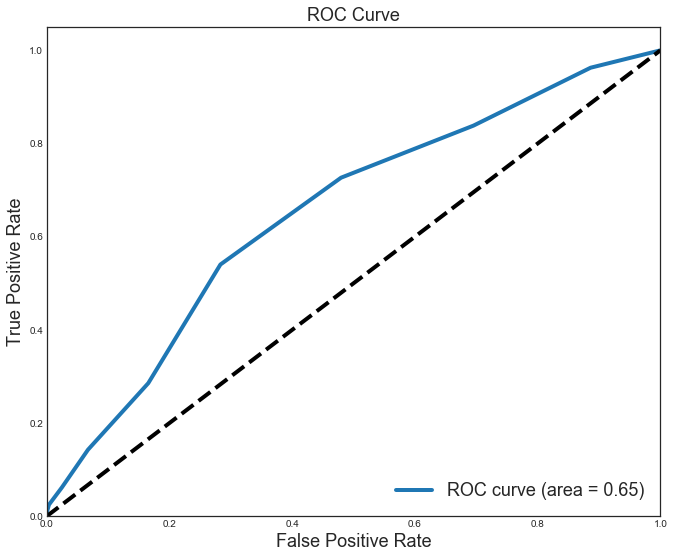

In [32]:
# Let's draw that:
plt.style.use('seaborn-white')
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc="lower right", fontsize=18);

## Feature Importance

In [33]:
df_x  = pd.DataFrame(Xvec_test.todense(),
             columns=tvec.get_feature_names())

In [34]:
fi = pd.DataFrame({
        'feature':df_x.columns,
        'importance':my_model.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)

In [39]:
# Features most associated with target
top15=pd.DataFrame(fi.sort_values('importance', ascending=False).head(15))
top15['feature'].values

array(['high', 'friends', 'wedding', 'kids', 'big', 'best friends',
       'beauty', 'just', 'competition', 'woman', 'make', 'comedy', 'trio',
       'laid', 'stars'], dtype=object)

Text(0, 0.5, 'Feature Importance')

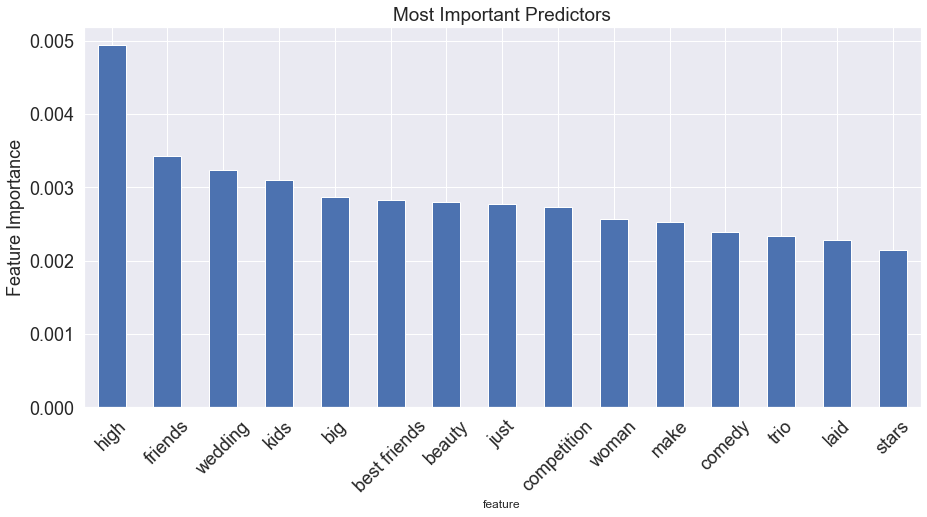

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="darkgrid", color_codes=None)
# sns.palplot(sns.color_palette("RdBu", n_colors=7))
ax = top15.set_index('feature').plot(kind='bar', legend=False, fontsize=18,  figsize=(15, 7))
plt.xticks(rotation = 45,  fontsize=18)
plt.title('Most Important Predictors',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=18)
plt.ylabel('Feature Importance', rotation=90,  fontsize=18)

## Test on new data

In [37]:
# newdata = train[train['target']==1]['overview'].sample(1).values
newdata = ['this is a test this is just a test funny funny joke ha']
tvec_test=tvec.transform(newdata)
preds_test=my_model.predict(tvec_test)
preds_test

array([0])

In [38]:
# pickle the vectorizer
file = open('vectorizer.pkl', 'wb')
pickle.dump(tvec, file)
file.close()